In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1. Data preprocessing & cleaning 
In this step we will take a quick look at the data and the columns in order to clean it.

In [105]:
data = pd.read_csv('take-home_exercise_data.csv', index_col=False)

In [106]:
data.drop(columns=['Unnamed: 0'], inplace=True)
data.head()

,prospectid,ordernumber,ordercreatedate,regtenure,customer_type_group,dnatestactivationdayid,daystogetresult_grp,dna_visittrafficsubtype,xsell_gsa,xsell_day_exact
0,93771712,127707306,2014-11-28,More than 120 days old,Existing Reg,2014-12-10,4 weeks,NaN,1,38.0
1,123112555,114401425,2013-12-05,Order prior to reg,New Reg,2014-01-13,4 weeks,NaN,1,40.0
2,171965960,159656050,2016-11-25,Order prior to reg,New Reg,NaN,-1,Paid Search Non Brand,0,NaN
3,175522116,165370285,2017-03-08,<=60 days,Existing Reg,NaN,-1,Email Programs,0,NaN
4,149288086,132837125,2015-03-30,Order prior to reg,New Reg,2015-04-06,4 weeks,NaN,0,NaN


As we can see from info function call on the dataframe, there are 251942 rows, 251942 distinct orders and 200000 unique customers.
The columns that have missing values are the following: dnatestactivationdayid, dna_visittrafficsubtype.
The xsell_day_exact field MIGHT contain missing values, but because its value can be null due to non subscription to ACOM, we cannot decide with only using the info function call.
The xsell_day_exact field has no mssing values, as every record where xsell_gsa equals 1, the xsell_day_exact is populated.

In [107]:
data.info()
print('\ndata shape '+str(data.shape))
print('\nUnique orders '+str(data['ordernumber'].nunique()))
print('\nUnique customers '+str(data['prospectid'].nunique()))
missing_xsell_day_exact = data[data['xsell_gsa']==1 & data['xsell_day_exact'].isna()].shape[0]
print('\nNumber of missing values for xsell_day_exact '+str(missing_xsell_day_exact))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251942 entries, 0 to 251941
Data columns (total 10 columns):
prospectid                 251942 non-null int64
ordernumber                251942 non-null int64
ordercreatedate            251942 non-null object
regtenure                  251942 non-null object
customer_type_group        251942 non-null object
dnatestactivationdayid     178845 non-null object
daystogetresult_grp        251942 non-null object
dna_visittrafficsubtype    189093 non-null object
xsell_gsa                  251942 non-null int64
xsell_day_exact            40579 non-null float64
dtypes: float64(1), int64(3), object(6)
memory usage: 19.2+ MB

data shape (251942, 10)

Unique orders 251942

Unique customers 200000

Number of missing values for xsell_day_exact 0


Let's see the values of some of the categorical fields.
Since some of the values in fields like regtenure and days_needed_for_DNA_result are marked as 'No Reg Date' or '-1', it means that even though the values are present, they are unknown. We will subsitute the values in all the records where such cases occur with null/nan.
After replacement, we have 809 records with missing values for regtenure field and 101965 record with missing values for daystogetresult_grp field.
This leaves us with a total of 450083 missing values in the entire dataset.

In [108]:
[print(label+' '+str(data[label].nunique())) for label in data.columns]
print('\ndays passed email provided')
print(data.regtenure.unique())
print('\ncustomer type')
print(data.customer_type_group.unique())
print('\ndays needed for DNA result ')
print(data.daystogetresult_grp.unique())
print('\ndna traffic visit channel')
print(data.dna_visittrafficsubtype.unique())

prospectid 200000
ordernumber 251942
ordercreatedate 1767
regtenure 9
customer_type_group 3
dnatestactivationdayid 1790
daystogetresult_grp 12
dna_visittrafficsubtype 46
xsell_gsa 2
xsell_day_exact 1471

days passed email provided
['More than 120 days old' 'Order prior to reg' '<=60 days' '<=120 days'
 '<=10 days' '<=30 days' '<=20 day' 'No Reg Date' '<=90 days']

customer type
['Existing Reg' 'New Reg' 'Acom Sub']

days needed for DNA result 
['4 weeks' '-1' '6 weeks' '5 weeks' '3 weeks' '7 weeks' '10 weeks'
 '2 weeks' '>10weeks' '9 weeks' '8 weeks' '1 week']

dna traffic visit channel
[nan 'Paid Search Non Brand' 'Email Programs' 'email no source id'
 'direct non-homepage' 'Email Campaigns' 'direct dna homepage'
 'direct core homepage' 'geo-redirect' 'paid search – dna brand'
 'organic dna brand' 'internal referrals' 'paid search – core brand'
 'Affiliate External' 'organic core brand' 'External Paid Media'
 'content marketing' 'organic nonbrand' 'Radio Brand/PR'
 'Paid Search GDN ' 

In [109]:
data.replace(to_replace={'No Reg Date': np.nan, '-1': np.nan}, inplace=True)
print('\ndays passed email provided # missing values')
print(data.regtenure.isna().sum())
print('\ndays needed for DNA result # missing values')
print(data.daystogetresult_grp.isna().sum())
print('\ntotal number of missing values')
print(data.isna().sum().sum())


days passed email provided # missing values
809

days needed for DNA result # missing values
101965

total number of missing values
450083


Let's work on the timestamp fields. We will convert them to timestamp data types and obtain the year, month and day for each. Also we will obtain the number of days that have passed between DNA test order and activation.

In [142]:
data.ordercreatedate = pd.to_datetime(data.ordercreatedate)
data['order_year'] = data.ordercreatedate.apply(lambda x: x.date().year)
data['order_month'] = data.ordercreatedate.apply(lambda x: x.date().month)
data['order_day'] = data.ordercreatedate.apply(lambda x: x.date().day)

data.dnatestactivationdayid = pd.to_datetime(data.dnatestactivationdayid)
data['activation_year'] = data.dnatestactivationdayid.apply(lambda x: x.date().year)
data['activation_month'] = data.dnatestactivationdayid.apply(lambda x: x.date().month)
data['activation_day'] = data.dnatestactivationdayid.apply(lambda x: x.date().day)
data['days_order_activation'] = (data['dnatestactivationdayid'] - data['ordercreatedate'])

## 2. Investigate cross sell rate

In [182]:
data_ACOM = data[data['xsell_gsa']==1]
data_ACOM_xsell = data_ACOM[data_ACOM['xsell_day_exact'] <= 120]

In [184]:
print('# customers that are ACOM subscribers '+str(data[data.xsell_gsa==1].shape[0]))
print('# unique customers that are ACOM subscribers '+str(data[data.xsell_gsa==1]['prospectid'].nunique()))
print('# customers that cross sell to subscription '+str(data_ACOM_xsell.shape[0]))
print('# unique customers that cross sell to subscription '+str(data_ACOM_xsell['prospectid'].nunique()))

# customers that are ACOM subscribers 40579
# unique customers that are ACOM subscribers 40579
# customers that cross sell to subscription 31216
# unique customers that cross sell to subscription 31216


In [185]:
data_ACOM_xsell.median(axis=0)

prospectid                      1.297e+08
ordernumber                   1.49988e+08
xsell_gsa                               1
xsell_day_exact                         6
order_year                           2016
order_month                             8
order_day                              16
activation_year                      2016
activation_month                        6
activation_day                         15
days_order_activation    10 days 00:00:00
dtype: object

In [170]:
data.describe()

,prospectid,ordernumber,xsell_gsa,xsell_day_exact,order_year,order_month,order_day,activation_year,activation_month,activation_day,days_order_activation
count,2.519420e+05,2.519420e+05,251942.000000,40579.000000,251942.000000,251942.000000,251942.000000,178845.000000,178845.000000,178845.000000,178845
mean,1.144561e+08,1.455821e+08,0.161065,140.674043,2015.438462,7.119583,16.471176,2015.448517,6.298840,15.680075,30 days 16:05:59.426318
std,5.277515e+07,1.752503e+07,0.367591,668.588251,1.419499,3.835034,8.975839,1.240606,3.819462,8.887869,307 days 01:34:40.476990
min,7.600000e+02,9.592366e+07,0.000000,0.000000,1900.000000,1.000000,1.000000,2012.000000,1.000000,1.000000,1 days 00:00:00
25%,7.189144e+07,1.356459e+08,0.000000,0.000000,2015.000000,3.000000,9.000000,2015.000000,3.000000,8.000000,7 days 00:00:00
50%,1.243254e+08,1.504135e+08,0.000000,22.000000,2016.000000,7.000000,17.000000,2016.000000,6.000000,16.000000,11 days 00:00:00
75%,1.649072e+08,1.599612e+08,0.000000,100.000000,2016.000000,11.000000,25.000000,2016.000000,10.000000,23.000000,22 days 00:00:00
max,1.795105e+08,1.667366e+08,1.000000,42302.000000,2017.000000,12.000000,31.000000,2017.000000,12.000000,31.000000,42462 days 00:00:00


In [216]:
def group_by_feature(data, feature):
    
    data_grouped = data.groupby([feature]).size().reset_index(name='count')
    data_grouped.sort_values(by='count', ascending=False, inplace=True)
    return data_grouped

In [298]:
def create_plot(ylabel, title, xlabels, xsizes, rotate):
    
    y_pos = np.arange(len(xlabels))    
    plt.bar(y_pos, xsizes, align='center', alpha=1, color="blue")
    if rotate is True:
        plt.bar(y_pos, xsizes, align='center', alpha=1, color="blue", orientation='horizontal')
    plt.xticks(y_pos, xlabels, rotation=0, fontsize = 10)
    plt.ylabel(ylabel)
    plt.title(title)
    if rotate is True:
        plt.rotate()
    plt.show()

In [286]:
groupby_xsell_days = group_by_feature(data_ACOM_xsell, 'xsell_day_exact')  
groupby_sell_days = group_by_feature(data_ACOM, 'xsell_day_exact')  

In [287]:
print(groupby_xsell_days.head(10))
print(groupby_sell_days.head())

    xsell_day_exact  count
0               0.0  13699
7               7.0    634
6               6.0    499
8               8.0    466
9               9.0    419
1               1.0    411
5               5.0    403
10             10.0    401
11             11.0    347
12             12.0    311
   xsell_day_exact  count
0              0.0  13699
7              7.0    634
6              6.0    499
8              8.0    466
9              9.0    419


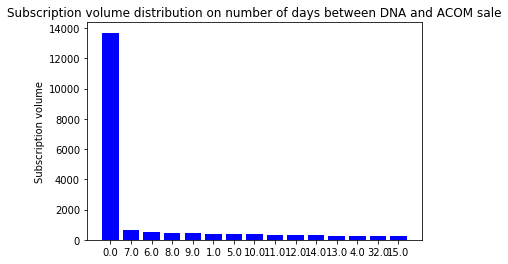

In [288]:
number_days = groupby_xsell_days['xsell_day_exact'].head(15)
count = groupby_xsell_days['count'].head(15)
create_plot('Subscription volume', 'Subscription volume distribution on number of days between DNA and ACOM sale', 
            number_days, count, False)

In [290]:
groupby_regtenure = group_by_feature(data_ACOM_xsell, 'regtenure')  
groupby_regtenure

,regtenure,count
6,More than 120 days old,16957
7,Order prior to reg,12128
0,<=10 days,729
4,<=60 days,371
5,<=90 days,293
2,<=20 day,239
1,<=120 days,227
3,<=30 days,204


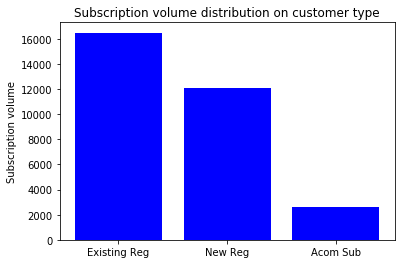

In [292]:
groupby_customer_type = group_by_feature(data_ACOM_xsell, 'customer_type_group')  
customer_type = groupby_customer_type['customer_type_group']
count = groupby_customer_type['count']
create_plot('Subscription volume', 'Subscription volume distribution on customer type', 
            customer_type, count, False)

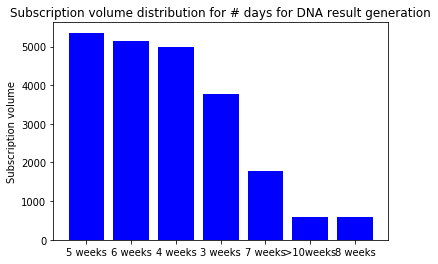

In [294]:
groupby_days_result = group_by_feature(data_ACOM_xsell, 'daystogetresult_grp')  
days_result = groupby_days_result['daystogetresult_grp'].head(7)
count = groupby_days_result['count'].head(7)
create_plot('Subscription volume', 'Subscription volume distribution for # days for DNA result generation', 
            days_result, count, False)

In [280]:
groupby_days_result

,daystogetresult_grp,count
5,5 weeks,5357
6,6 weeks,5142
4,4 weeks,4995
3,3 weeks,3779
7,7 weeks,1783
10,>10weeks,597
8,8 weeks,591
2,2 weeks,568
9,9 weeks,561
1,10 weeks,560


In [281]:
groupby_visit_type = group_by_feature(data_ACOM_xsell, 'dna_visittrafficsubtype')  
groupby_visit_type.head(10)

,dna_visittrafficsubtype,count
28,direct core homepage,4915
40,paid search – dna brand,3126
17,Paid Search Non Brand,2175
6,Email Campaigns,2042
39,paid search – core brand,1759
35,internal referrals,1569
37,organic dna brand,1316
30,direct non-homepage,1206
29,direct dna homepage,1014
36,organic core brand,997


In [282]:
groupby_days_order_activation = group_by_feature(data_ACOM_xsell, 'days_order_activation')  
groupby_days_order_activation.head(15)

,days_order_activation,count
6,7 days,3139
5,6 days,2835
7,8 days,2405
4,5 days,1952
8,9 days,1859
9,10 days,1522
10,11 days,1150
11,12 days,912
3,4 days,878
12,13 days,792


Let's see if subscription is influenced by date when the kit was activated (year, month, day of the month).

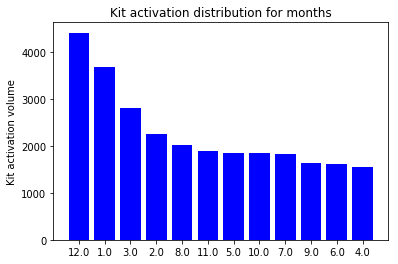

In [299]:
groupby_month = group_by_feature(data_ACOM_xsell, 'activation_month')  
months = groupby_month['activation_month']
count = groupby_month['count']
create_plot('Kit activation volume', 'Kit activation distribution for months', 
            months, count, False)

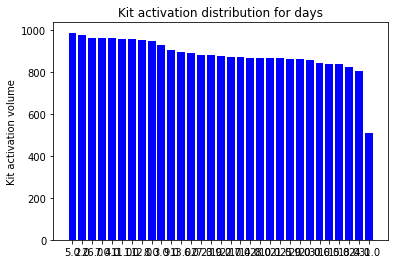

In [300]:
groupby_days = group_by_feature(data_ACOM_xsell, 'activation_day')  
days = groupby_days['activation_day']
count = groupby_days['count']
create_plot('Kit activation volume', 'Kit activation distribution for days', 
            days, count, False)

In [209]:
data.columns

Index(['prospectid', 'ordernumber', 'ordercreatedate', 'regtenure',
       'customer_type_group', 'dnatestactivationdayid', 'daystogetresult_grp',
       'dna_visittrafficsubtype', 'xsell_gsa', 'xsell_day_exact', 'order_year',
       'order_month', 'order_day', 'activation_year', 'activation_month',
       'activation_day', 'days_order_activation'],
      dtype='object')